In [17]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import InMemorySaver
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

In [18]:
llm = ChatOllama(model="qwen3:8b")

In [19]:
# tools
search_tool = DuckDuckGoSearchRun(region="us-en")


@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic calculation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation: {operation}"}

        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

In [20]:
# list of tools
tools = [search_tool, calculator]

In [21]:
# make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [22]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [23]:
# nodes creation
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call"""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)

In [24]:
graph = StateGraph(ChatState)

checkpointer = InMemorySaver()

graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [25]:
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)

In [26]:
chatbot = graph.compile(checkpointer=checkpointer)

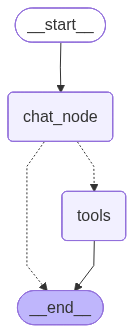

In [27]:
chatbot

In [30]:
# normal chat
config1 = {"configurable": {"thread_id":"1"}}

out = chatbot.invoke({"messages": [HumanMessage(content="hi")]}, config=config1)

print(out["messages"][-1].content)

Hello! How can I assist you today? 😊


In [31]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2 * 3?")]}, config=config1)
print(out["messages"][-1].content)

{"first_num": 2.0, "second_num": 3.0, "operation": "mul", "result": 6.0}


In [32]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="Tell me news about US tariff war")]}, config=config1)
print(out["messages"][-1].content)

2 days ago · Latest news headlines from India & around the world. Check out today’s news coverage live with videos & photos on NDTV.com. Latest News Today: Breaking news on Politics, Business, Sports, Bollywood, Education, Science. Latest News on Politics, India, Current affairs. 11 hours ago · Jan Suraaj has now declared nominees for 116 out of the state’s 243 seats. The latest list includes 20 candidates from reserved constituencies and 45 from general seats. Today's news: Get latest and Breaking News on Politics, Business, Lifestyle, Entertainment and Sports along with News updates from around the world. Also, find English News, live coverage … Today's breaking news on politics, sports, entertainment, business, life style and many more on Times of India.


In [33]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="My name is tushar")]}, config=config1)
print(out["messages"][-1].content)

Hello, Tushar! How can I assist you today? 😊


In [35]:
out = chatbot.invoke({"messages": [HumanMessage(content="what is my name")]}, config=config1)
print(out["messages"][-1].content)

Your name is Tushar! 😊 How can I assist you today?
